# Frozen Lake Monte Carlo Control

In [1]:
using ReinforcementLearning, Plots, Random
pyplot()

Plots.PyPlotBackend()

Firstly, we will define our environment. We will make it recognizable for the [<tt>ReinforcementLearning.jl</tt>]( https://juliareinforcementlearning.org/).

Let us start with predefined constants and functions:

In [2]:
#actions coded as :left => 1, :down => 2, :right => 3, :up => 4
#arrows are corresponding to actions
arrows = Dict(1 => '⇐', 2 => '⇓', 3 => '⇒', 4 => '⇑');

grid4x4= ['S' 'F' 'F' 'F';
        'F' 'H' 'F' 'H';
        'F' 'F' 'F' 'H';
        'H' 'F' 'F' 'G'];

grid8x8 =['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F';
        'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F';
        'F' 'F' 'F' 'H' 'F' 'F' 'F' 'F';
        'F' 'F' 'F' 'F' 'F' 'H' 'F' 'F';
        'F' 'F' 'F' 'H' 'F' 'F' 'F' 'F';
        'F' 'H' 'H' 'F' 'F' 'F' 'H' 'F';
        'F' 'H' 'F' 'F' 'H' 'F' 'H' 'F';
        'F' 'F' 'F' 'H' 'F' 'F' 'F' 'G';];

In [3]:
#Auxilliary functions
function get_grid(dim, p_holes, seed = 234)
    Random.seed!(seed)
    grid = [rand() < p_holes ? 'H' : 'F' for i in 1:dim, j in 1:dim]
    grid[1,1] = 'S'
    grid[end,end] = 'G'
    return grid
end

function random_policy(grid,actions = actions)
    P = rand(Int,size(grid))
    for i = 1:length(grid)
        P[i] = rand(1:length(actions))
    end
    return P
end

function print_policy(P, grid, arrows = arrows)
    Policy = rand(Char,size(grid))
    for i = 1:length(grid)
        if grid[i] == 'F' || grid[i] == 'S' 
            Policy[i] = arrows[P[i]]
        elseif grid[i] == 'H' 
            Policy[i] = '⦷'
        else
            Policy[i] = grid[i]
        end
    end
    return Policy
end

print_policy (generic function with 2 methods)

#Now, we will define the environment as a mutable struct:


In [4]:

mutable struct FrozenLakeEnv <: AbstractEnv
    reward::Union{Nothing, AbstractFloat}
    rewards::Dict{Char, Float64} 
    actions::Dict{Int64, Tuple{Int64, Int64}}  
    world::Matrix{Char} 
    ES::Bool 
    position::Int 
    done::Bool
end
Main.FrozenLakeEnv

FrozenLakeEnv

and define a constructor function of Frozen Lake environment:

In [5]:
function FrozenLakeEnv(grid::Union{Int,Symbol} = :grid4x4; ES::Bool = false) 
    if typeof(grid) == Int
        world = get_grid(grid, 0.1)
    elseif grid == :grid4x4
        world = grid4x4
    elseif grid == :grid8x8
        world = grid8x8
    else
        @error "unknown grid"
    end
    ES == true ? position = rand(1:length(world)) : position = 1
    return FrozenLakeEnv(nothing, Dict('S' => -0.05, 'G' => 1.0, 'H' => -1.0, 'F' => -0.05),
    Dict(1 => (0,-1), 2 => (1,0), 3 => (0,1), 4 => (-1,0)), 
        world, ES, position, false)
    
end

FrozenLakeEnv

Now, we must define the minimal interface of the environment. Without this functions code will not work properly:

In [6]:
#functions:
RLBase.action_space(env::FrozenLakeEnv) = Base.OneTo(length(env.actions))
RLBase.state_space(env::FrozenLakeEnv) = Base.OneTo(length(env.world))
RLBase.reward(env::FrozenLakeEnv) = env.reward
RLBase.state(env::FrozenLakeEnv, ::Observation, ::DefaultPlayer) = env.position
RLBase.is_terminated(env::FrozenLakeEnv) = env.done
function RLBase.reset!(env::FrozenLakeEnv) 
    env.reward = nothing
    env.done = false
    env.ES == true ? env.position = rand(state_space(env)) : env.position = 1
end

and the most important function that controls the  movement:

In [7]:

function RLBase.act!(x::FrozenLakeEnv, action)
    @assert action in action_space(x)
    direction = x.actions[action]
    cartesian_state = (CartesianIndices(x.world)[x.position][1],
                        CartesianIndices(x.world)[x.position][2])
    sides = filter(y -> !(y in [direction, direction .* -1]), collect(values(x.actions)))
    p = rand()
    if p <= 0.8
        new_state = cartesian_state .+ direction
    elseif p <= 0.9
        new_state = cartesian_state .+ sides[1]
    else
        new_state = cartesian_state .+ sides[2]
    end
    if new_state[1] in (1:size(x.world,1)) && new_state[2] in (1:size(x.world,2))
        x.position = LinearIndices(x.world)[new_state[1],new_state[2]]
        x.reward = x.rewards[x.world[x.position]]
    else
        x.position = LinearIndices(x.world)[cartesian_state[1],cartesian_state[2]]
        x.reward = x.rewards[x.world[x.position]]
    end
    x.done = (x.reward == 1.0 || x.reward == -1.0)
end

Now we could test if the Frozen Lake enviroment works and debug it if neccessary:

In [8]:
env = FrozenLakeEnv(:grid4x4, ES = false);
RLBase.test_runnable!(env);

Test Summary:                    | Pass  Total      Time
random policy with FrozenLakeEnv | 2000   2000  27m19.0s


[Hooks](https://juliareinforcementlearning.org/docs/How_to_use_hooks/) are one of the biggest advantages of the <tt>ReinforcementLearning.jl</tt> package. They allow us to collect some useful information about the training process. Here is the simple example how we could use them:

In [9]:
hook = TotalRewardPerEpisode(; is_display_on_exit=true)

TotalRewardPerEpisode{Val{true}, Float64}(Float64[], 0.0, true)

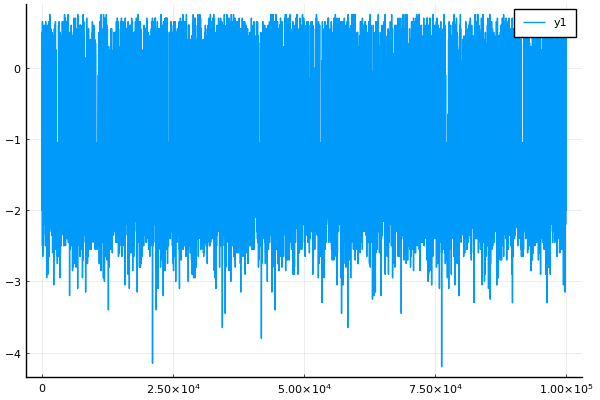

In [10]:
run(RandomPolicy(action_space(env)), env, StopAfterNEpisodes(100_000), hook)


plot(hook.rewards)

In [11]:
run(RandomPolicy(action_space(env)), env, StopAfterNEpisodes(200_000), DoEveryNEpisodes(;n=100) do t, policy, env
               # In real world cases, the policy is usually wrapped in an Agent,
               # we need to extract the inner policy to run it in the *actor* mode.
               # Here for illustration only, we simply use the original policy.
       
               # Note that we create a new instance of CartPoleEnv here to avoid
               # polluting the original env.
       
               hook = TotalRewardPerEpisode(;is_display_on_exit=true)
               run(policy, FrozenLakeEnv(), StopAfterNEpisodes(10), hook)
       
               # now you can report the result of the hook.
               println("avg reward at episode $t is: $(sum(hook.rewards)/length(hook.rewards))")
           end
 )


avg reward at episode 100 is: -1.27
avg reward at episode 200 is: -1.0899999999999999
avg reward at episode 300 is: -1.4300000000000002
avg reward at episode 400 is: -1.33
avg reward at episode 500 is: -1.275
avg reward at episode 600 is: -1.425
avg reward at episode 700 is: -1.35
avg reward at episode 800 is: -1.355
avg reward at episode 900 is: -1.33
avg reward at episode 1000 is: -1.275
avg reward at episode 1100 is: -1.45
avg reward at episode 1200 is: -1.6200000000000003
avg reward at episode 1300 is: -1.305
avg reward at episode 1400 is: -1.3199999999999998
avg reward at episode 1500 is: -1.1600000000000001
avg reward at episode 1600 is: -1.4000000000000001
avg reward at episode 1700 is: -1.225
avg reward at episode 1800 is: -1.3
avg reward at episode 1900 is: -1.365
avg reward at episode 2000 is: -1.3350000000000002
avg reward at episode 2100 is: -1.2550000000000001
avg reward at episode 2200 is: -1.3850000000000002
avg reward at episode 2300 is: -1.4399999999999997
avg reward a

Progress:  87%|████████████████████████████████████     |  ETA: 0:00:00

avg reward at episode 173700 is: -1.405
avg reward at episode 173800 is: -1.42
avg reward at episode 173900 is: -1.33
avg reward at episode 174000 is: -1.2349999999999999
avg reward at episode 174100 is: -1.16
avg reward at episode 174200 is: -1.31
avg reward at episode 174300 is: -1.265
avg reward at episode 174400 is: -1.4700000000000002
avg reward at episode 174500 is: -1.475
avg reward at episode 174600 is: -1.1900000000000002
avg reward at episode 174700 is: -1.2
avg reward at episode 174800 is: -1.1500000000000001
avg reward at episode 174900 is: -1.3250000000000002
avg reward at episode 175000 is: -1.1949999999999998
avg reward at episode 175100 is: -1.31
avg reward at episode 175200 is: -1.065
avg reward at episode 175300 is: -1.13
avg reward at episode 175400 is: -1.3450000000000002
avg reward at episode 175500 is: -1.3199999999999998
avg reward at episode 175600 is: -1.33
avg reward at episode 175700 is: -1.185
avg reward at episode 175800 is: -1.36
avg reward at episode 1759

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01



avg reward at episode 190600 is: -1.2000000000000002
avg reward at episode 190700 is: -1.2699999999999998
avg reward at episode 190800 is: -1.4200000000000004
avg reward at episode 190900 is: -1.24
avg reward at episode 191000 is: -1.295
avg reward at episode 191100 is: -1.3400000000000003
avg reward at episode 191200 is: -1.2000000000000002
avg reward at episode 191300 is: -1.4600000000000002
avg reward at episode 191400 is: -1.255
avg reward at episode 191500 is: -1.4800000000000004
avg reward at episode 191600 is: -1.32
avg reward at episode 191700 is: -1.3050000000000002
avg reward at episode 191800 is: -1.2449999999999999
avg reward at episode 191900 is: -1.23
avg reward at episode 192000 is: -1.3100000000000003
avg reward at episode 192100 is: -1.225
avg reward at episode 192200 is: -1.325
avg reward at episode 192300 is: -1.435
avg reward at episode 192400 is: -1.495
avg reward at episode 192500 is: -1.5150000000000001
avg reward at episode 192600 is: -1.4300000000000002
avg re

DoEveryNEpisodes{PostEpisodeStage, var"#6#7"}(var"#6#7"(), 100, 200000)

or in a more sophisticated case:

In [12]:
policy = QBasedPolicy(
           learner = TDLearner(
                            TabularQApproximator(
                                n_state = length(state_space(env)),
                               n_action = length(action_space(env)),), :SARS, γ=0.999),
           explorer = EpsilonGreedyExplorer(0.1)
       )

QBasedPolicy{TDLearner{:SARS, TabularQApproximator{Matrix{Float64}}}, EpsilonGreedyExplorer{:linear, false, TaskLocalRNG}}(TDLearner{:SARS, TabularQApproximator{Matrix{Float64}}}(TabularQApproximator{Matrix{Float64}}([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]), 0.999, 0.01, 0), EpsilonGreedyExplorer{:linear, false, TaskLocalRNG}(0.1, 1.0, 0, 0, 1, TaskLocalRNG()))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


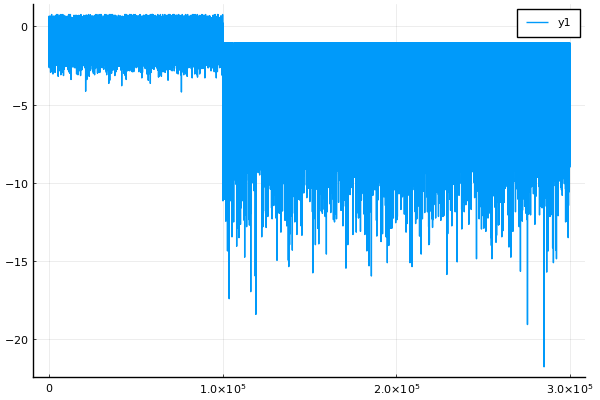

In [13]:
run(policy, env, StopAfterNEpisodes(200_000), hook)

plot(hook.rewards)

In [14]:
agentMC = Agent(
           policy = policy,
           trajectory = Trajectory( ElasticArraySARTSATraces(;
               state = Int64 => (),
               action = Int64 => (),
               reward = Float64 => (),
               terminal = Bool => (),
           ), DummySampler(), InsertSampleRatioController())
       )

Agent{QBasedPolicy{TDLearner{:SARS, TabularQApproximator{Matrix{Float64}}}, EpsilonGreedyExplorer{:linear, false, TaskLocalRNG}}, Trajectory{EpisodesBuffer{(:state, :next_state, :action, :next_action, :reward, :terminal), Tuple{Int64, Int64, Int64, Int64, Trace{ElasticArrays.ElasticVector{Float64, Vector{Float64}}, SubArray{Float64, 0, ElasticArrays.ElasticVector{Float64, Vector{Float64}}, Tuple{Int64}, true}}, Trace{ElasticArrays.ElasticVector{Bool, Vector{Bool}}, SubArray{Bool, 0, ElasticArrays.ElasticVector{Bool, Vector{Bool}}, Tuple{Int64}, true}}}, ElasticArraySARTSATraces{Tuple{MultiplexTraces{(:state, :next_state), Trace{ElasticArrays.ElasticVector{Int64, Vector{Int64}}, SubArray{Int64, 0, ElasticArrays.ElasticVector{Int64, Vector{Int64}}, Tuple{Int64}, true}}, Int64}, MultiplexTraces{(:action, :next_action), Trace{ElasticArrays.ElasticVector{Int64, Vector{Int64}}, SubArray{Int64, 0, ElasticArrays.ElasticVector{Int64, Vector{Int64}}, Tuple{Int64}, true}}, Int64}, Trace{ElasticAr

In [15]:
run(agentMC, env, StopAfterNEpisodes(200_000), hook)

plot(hook.rewards)

LoadError: MethodError: no method matching optimise!(::TDLearner{:SARS, TabularQApproximator{Matrix{Float64}}}, ::@NamedTuple{state::Int64, next_state::Int64, action::Int64, next_action::Int64, reward::Float64, terminal::Bool})
The function `optimise!` exists, but no method is defined for this combination of argument types.

[0mClosest candidates are:
[0m  optimise!(::TDLearner, [91m::@NamedTuple{state::I1, next_state::I1, action::I2, reward::F2, terminal::Bool}[39m) where {I1<:Number, I2<:Number, F2<:AbstractFloat}
[0m[90m   @[39m [35mReinforcementLearningCore[39m [90mC:\Users\barto\.julia\packages\ReinforcementLearningCore\BYdWk\src\policies\learners\[39m[90m[4mtd_learner.jl:78[24m[39m
[0m  optimise!(::TDLearner, [91m::AbstractStage[39m, [91m::Trajectory[39m)
[0m[90m   @[39m [35mReinforcementLearningCore[39m [90mC:\Users\barto\.julia\packages\ReinforcementLearningCore\BYdWk\src\policies\learners\[39m[90m[4mtd_learner.jl:85[24m[39m
[0m  optimise!(::TDLearner{:SARS}, [91m::PostActStage[39m, [91m::NamedTuple[39m)
[0m[90m   @[39m [35mReinforcementLearningCore[39m [90mC:\Users\barto\.julia\packages\ReinforcementLearningCore\BYdWk\src\policies\learners\[39m[90m[4mtd_learner.jl:92[24m[39m
[0m  ...


After learning how to build agents with the [<tt>ReinforcementLearning.jl</tt>]( https://juliareinforcementlearning.org/) package, we could implement our own agent and understand the logic of the Monte Carlo algorithm:

In [ ]:
mutable struct AgentMC
    env::FrozenLakeEnv
    ϵ::Float64
    β::Float64 #stopa dyskonta
    Q::Array{Float64,2}#macierz wartosci dla kazdej z par:stan,akcja
    C::Array{Float64,2} #macierz wystapien dla kazdej z par:stan,akcja
    π::Array{Int} #strategia agenta
end

function AgentMC(env; ϵ = .2, β = 0.999)
    return AgentMC(env,ϵ, β,
        zeros(length(env.world), length(action_space(env))), 
        zeros(length(env.world), length(action_space(env))),
        rand(1:length(action_space(env)),length(env.world)))
end

Now, we could implement the logic of the learning process:

In [ ]:
function get_episode(agent, π = agent.π; maxstep = 1000)
    step = 1
    if agent.env.ES == true 
        S = rand(state_space(agent.env)) 
        agent.env.position = S
        action = rand(action_space(agent.env))
    else
        S = 1
        rand() < agent.ϵ ? action = rand(action_space(agent.env)) : action = π[S]
    end
    act!(agent.env, action)
    r = agent.env.reward
    episode = [(S, action, r)]
    if is_terminated(agent.env) 
        reset!(agent.env)
        return episode
    end
    while step < maxstep
        S = state(agent.env)
        (rand() < agent.ϵ) && (agent.env.ES == false) ? action = rand(action_space(agent.env)) : action = π[S]
        act!(agent.env, action)
        r = agent.env.reward
        push!(episode, (S, action,r))
        if is_terminated(agent.env)
            reset!(agent.env)
            break
        end
        step +=1
    end
    return episode
end

In [ ]:
function update!(agent)
    episode = get_episode(agent)
    R = 0
    occur_first = reverse(vcat(findfirst.(isequal.(unique(episode)), [episode]), length(episode) + 1))
    for k = 2:length(occur_first)
        for i = occur_first[k-1] - 1:-1:occur_first[k]
            state,action,r = episode[i]
            R = agent.β*R + r
        end
        state,action,r = episode[occur_first[k]]
        agent.C[state,action] += 1
        agent.Q[state,action] += (R - agent.Q[state,action])/ agent.C[state,action]
        agent.π[state] = argmax(agent.Q[state,:])
    end  
    episode[end][3] == 1.0 ? (return 1.0) : (return 0.0)
end

In [ ]:
function MC!(agent; maxit = 100000)
    iter = 0
    successes = 0.0
    success_rate = []
    while iter < maxit
        successes += update!(agent)
        push!(success_rate, successes/iter)
        iter +=1
    end
    return success_rate
end

Finally, we could run the experiments and take a look at the results:

In [ ]:
#xploring starts 
agent = AgentMC(FrozenLakeEnv(:grid4x4, ES = true));
MC!(agent, maxit = 500_000)
print_policy(agent.π, agent.env.world)

In [ ]:
#without exploring starts
agent = AgentMC(FrozenLakeEnv(:grid4x4, ES = false));
success_rate = MC!(agent; maxit = 500_000)
print_policy(agent.π, agent.env.world)

In [ ]:
plot(success_rate[2:end], xlabel = "Iteration", ylabel = "success rate", legend = false)